In [ ]:
# !pip install gym

import os
import datetime
import numpy as np
import gym
import matplotlib.pyplot as plt
import json

In [ ]:
# Set the constants and hyperparameters
# переписать в словарь чтобы сохранять и читать в json
DISCRETION = [80, 80]
LR = 0.12
DISCOUNT = 0.985
EPS = 0.7
EPOCHS = 200_000
best_reward = -500
ENV_NAME = 'MountainCar-v0'

RESET_Q = True

#how often to save Q table
SAVE_EVERY = 100

In [ ]:
#Create folder for every run
folder_name = f'Run_{datetime.datetime.now().strftime("%Y-%m-%d_(%H-%M-%S)")}'
try:
    os.mkdir(folder_name)
except OSError:
    print('Creating directory for saving results failed')

# Save parameters to results folder
with open(f'{folder_name}/Params.txt', 'w') as file:
    file.write(f'Environment: {ENV_NAME}\nDiscretion: {DISCRETION}\nLearning rate: {LR}\nDiscount: {DISCOUNT}\nEpsilon: {EPS}\nEpochs: {EPOCHS}\nReset Q: {RESET_Q}')

# Create environment
env = gym.make(ENV_NAME)

# Hepler to convert state from float 2 element array to int two element array. then feed to Q indexing
observ_high = env.observation_space.high
observ_low = env.observation_space.low
chunk_size = (observ_high - observ_low) / DISCRETION


def chunkify(state):    
    observation = (state - observ_low) / chunk_size
    return tuple(np.rint(observation).astype(np.int))


######################################
## Let's go###########################
######################################

if RESET_Q:
    # Init Q-table
    Q = np.random.uniform(low=-2, high=-0.5, size=(DISCRETION + [env.action_space.n]))
    print("Q table created")

# A historican
D = {'Total reward' :[], 'Frames run' : [], 'Epoch number' : []}

# Start the main loop
print("Starting epoch loop")
for epoch in range(EPOCHS):

    # Init new epoch
    # print("\nEpoch running: {}".format(epoch))
    state = env.reset()
    total_reward = 0
    done = False
    frames = 0

    while not done:

        # Convert state to integer indexes
        chunked_state = chunkify(state)

        # Action is the index of largest Q in given state
        action = np.argmax(Q[chunked_state])
        # print("Action: {}".format(action))

        # Make step in the environment
        new_state, reward, done, _ = env.step(action)

        # Render every 200th episode
        if (epoch % 200 == 0) & (best_reward > -200):
            # env.render()
            pass

        new_chunked_state = chunkify(new_state)

        # Update current Q for different cases: game is running, game won, game ended and not won
        if not done:
            Q[chunked_state[0], chunked_state[1], action] = (1 - LR) * Q[
                chunked_state[0], chunked_state[1], action] + LR * (reward + DISCOUNT * np.max(Q[new_chunked_state]))

        elif new_state[0] >= env.goal_position:
            Q[chunked_state[0], chunked_state[1], action] = 0
            print("Goal achieved at epoch {}".format(epoch))

        else:
            Q[chunked_state[0], chunked_state[1], action] = (1 - LR) * Q[
                chunked_state[0], chunked_state[1], action] + LR * reward

        # update state and total reward
        state = new_state
        total_reward += reward
        frames += 1
    
    # Add epoch statistics to history
    D['Total reward'].append(total_reward)
    D['Frames run'].append(frames)
    D['Epoch number'].append(epoch)

# this is number based on knowledge that any good agent should be better that this, just to save disk space
     
        
    # Case we got best reward: update Best reward, update Q table file
    if total_reward > best_reward:

        best_reward = total_reward
        print("Best reward: {}".format(best_reward))
        
        if total_reward > -120: 
            # Save Q table to file for the best runs           
            np.save(f'{folder_name}/Q_table_{total_reward}_result_step_{epoch}', Q)
            print("Q table written to file")

    # Save_every steps
    if (epoch % SAVE_EVERY == 0) and (total_reward > -120):
        np.save(f'{folder_name}/Q_table_{total_reward}_result_step_{epoch}', Q)
        print("Q table written to file")
            

with open(f'{folder_name}/History.json', 'w') as f:
    json.dump(D, f)
    
env.close()
print("Education is over")
print(f'Best reward is {best_reward}')

In [ ]:
# with open(f'{folder_name}/History.json', 'w') as f:
#     json.dump(D, f)

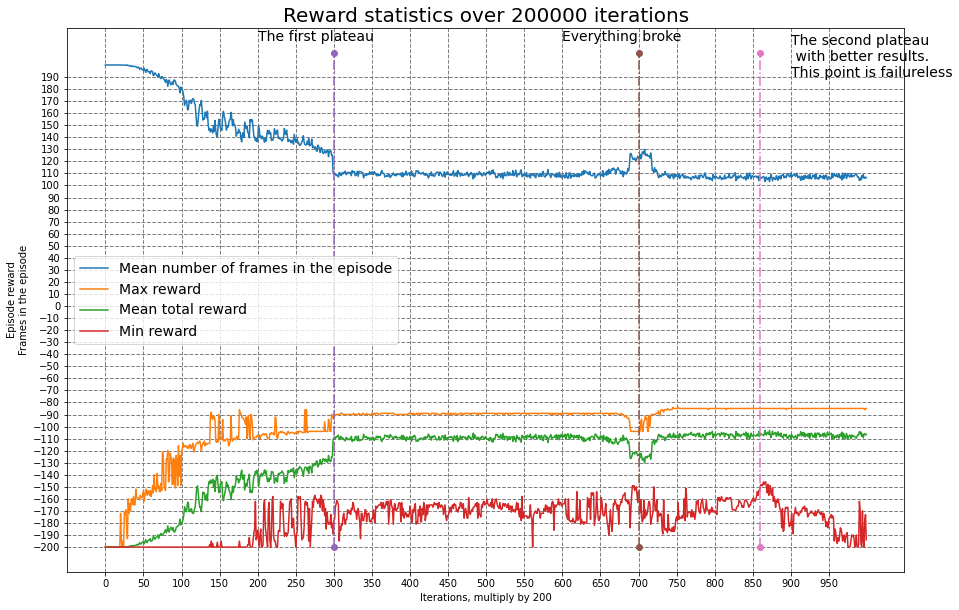

In [ ]:
#########################################
# SOME PLOT PRINTING    #################
#########################################

# We calculate mean, max and min total reward values every WINDOW_SIZE 

WINDOW_SIZE = 200
plot_data = {'Mean' : [], 'Min' : [], 'Max' : [], 'Mean number of frames' : []}

for i in range(int(EPOCHS/WINDOW_SIZE)):

    window = D['Total reward'][i*WINDOW_SIZE:(i+1)*WINDOW_SIZE]
    plot_data['Mean'].append(sum(window)/WINDOW_SIZE)
    plot_data['Min'].append(min(window))
    plot_data['Max'].append(max(window))

    plot_data['Mean number of frames'].append(sum(D['Frames run'][i*WINDOW_SIZE:(i+1)*WINDOW_SIZE])/WINDOW_SIZE)
    

plt.figure(figsize=(15, 10))
ax = plt.axes()
ax.grid()
ax.grid(color = 'grey', linewidth = 1, linestyle = '--')

plt.plot(range(int(EPOCHS/WINDOW_SIZE)), plot_data['Mean number of frames'], label='Mean number of frames in the episode')
plt.plot(range(int(EPOCHS/WINDOW_SIZE)), plot_data['Max'], label='Max reward')
plt.plot(range(int(EPOCHS/WINDOW_SIZE)), plot_data['Mean'], label='Mean total reward')
plt.plot(range(int(EPOCHS/WINDOW_SIZE)), plot_data['Min'], label='Min reward')



# # This region is interesting to us
plt.plot([300, 300], [-200, 210], 'o-.', )
plt.annotate('The first plateau', [200, 220], fontsize=14)

plt.plot([700, 700], [-200, 210], 'o-.', )
plt.annotate('Everything broke', [600, 220], fontsize=14)

plt.plot([860, 860], [-200, 210], 'o-.', )
plt.annotate('The second plateau\n with better results.\nThis point is failureless', [900, 190], fontsize=14)

# plt.plot([300, 360], [-10, -80], 'go--', )
# plt.plot([300, 340], [-10, -80], 'go--', )

plt.legend(loc=0, fontsize=14) # loc=0 means the best location
plt.title(f'Reward statistics over {EPOCHS} iterations', fontsize=20)
#plt.annotate('No failures plato for 2000 iterations', [220, 0], fontsize=16)

plt.xticks(np.arange(0, EPOCHS/WINDOW_SIZE, step=50))
plt.xlabel(f'Iterations, multiply by {WINDOW_SIZE}')
plt.yticks(np.arange(-200, 200, step=10))
plt.ylabel('Episode reward\nFrames in the episode')

plt.savefig(f'{folder_name}/Rewards_of_{EPOCHS}_epochs_over_{WINDOW_SIZE}_runs_windows')
plt.show()


# with open('log_mountain_car.npy', 'wb') as file:
#     np.save(file, )
#     pass
    # логировать на каком шаге был достигнут лучший результат
    # какова стабильность агента после выхода на плато 